# Prototype JulES v1

Check out the ReadMe page on Github for a description of JulES. This is a demo of the prototype implementation of JulES in a stepwise manner. Here are some of the most important steps: 
- Load the TuLiPa and JulES code on parallel processors so that we can run scenarios and subsystems in parallel
- Decide on simulation and scenario parameters
- First time step in the simulation and initializing
    - Load datasets for the European power system/market.
    - Initialize and run price prognosis models
    - Do scenario modelling for the stochastic subsystem models
    - Initialize and run the stochastic subsystem models
    - Initialize and run the market clearing problem
    - Collect results
- Simulate the next time steps
    - Run price prognosis models, scenario modelling, stochastic subsystem models, market clearing and collect results for each time step
- Postprocess, store and plot results

### Import packages

In [1]:
using DataFrames, Plots, Statistics, JSON, Distributed, Clustering
#plotlyjs();

### Prepare parallell processing - import code on all cores
The problem is simulated on 31 2.20 GHz processors running in parallel. TODO: Test on faster processors.

In [2]:
const numcores = 31

if nprocs() < numcores
    addprocs(numcores - nprocs())
end

@show nprocs();

nprocs() = 31


In [3]:
@everywhere using TuLiPa, Dates
@everywhere include(joinpath(dirname(pwd()),"src/JulES.jl"));

### Starting point and scenario settings
- Series simulation 30 years with moving horizons and two day time steps. Starting from model year 2025 and weather scenario 1981.
- 30 possible weather scenarios (1981-2010) that can be used to consider uncertainty (we use scenario modelling later)
- Scenarios are phased in after two days
    - First two days have perfect information from simulation/main scenario
    - Next 5 weeks combines simulation/main scenario and scenario X. Smooth transition.
    - After 5 weeks the simulation/main scenario is fully phased out.

In [4]:
datayear = 2025
scenarioyearstart = 1981
scenarioyearstop = 2011
totalscen = 30 # scenarios to consider uncertainty for

# Standard time for market clearing - perfect information so simple time type
tnormal = FixedDataTwoTime(getisoyearstart(datayear),getisoyearstart(scenarioyearstart))

# Phasein settings
phaseinoffsetdays = 2 # also simulation step length
phaseinoffset = Millisecond(Day(phaseinoffsetdays)) # phase in straight away from second stage scenarios
phaseindelta = Millisecond(Week(5)) # Phase in the second stage scenario over 5 weeks
phaseinsteps = 5 # Phase in second stage scenario in 5 steps

# Make scenario times for all uncertainty scenarios. List of tuples with tnormal, tphasein and scenarionumber
totalscentimes = []
for scen in 1:totalscen
    scentnormal = FixedDataTwoTime(getisoyearstart(datayear),getisoyearstart(scenarioyearstart + scen - 1))
    scentphasein = PhaseinTwoTime(getisoyearstart(datayear),getisoyearstart(scenarioyearstart), getisoyearstart(scenarioyearstart + scen - 1), phaseinoffset, phaseindelta, phaseinsteps);

    push!(totalscentimes, (scentnormal, scentphasein, scen))
end

### Price prognosis models uses NVEs Europe dataset for the TheMA model

This is a simplified version of the dataset NVE uses for its long-term power market analyses (for example https://www.nve.no/energi/analyser-og-statistikk/langsiktig-kraftmarkedsanalyse/). The dataset consist of:
- Detailed thermal units, aggregated hydro (Res, RoR, PHS), inelastic wind and solar, demands (inelastic with cutoff / load shedding price), storages (hydro and battery), transmission (ATC) and price areas (endogenous and exogenous). 
- Levels in 2021, 2025, 2030, 2040 and 2050 (e.g. commodity price levels, installed production/transmission/storage capacities etc.)
- Profiles (e.g. availability profiles for transmission or production units, commodity price profiles, weather scenario profiles 1981-2010 for demand, solar, wind and inflow etc.)

We cannot publish the full dataset, but many of the profiles for wind, solar, hydro and demand can be downloaded from https://www.nve.no/energi/analyser-og-statistikk/vaerdatasett-for-kraftsystemmodellene/.

#### NB! 
- In this demo we use the model year 2025. This scenario was made a couple of years ago and results should be considered outdated. A lot has happened in the power market since then. In addition the dataset is simplified.

In [5]:
sti_dataset = JSON.parsefile(joinpath(pwd(), "jules_config.json"), use_mmap=false)[1];

themastructure = json_to_elements(joinpath(sti_dataset, raw"data_fra_thema"), "dataset_thema.json")
themaseries = json_to_elements(joinpath(sti_dataset, raw"data_fra_thema"), "tidsserier_thema.json")

elements = vcat(themaseries,themastructure)
addscenariotimeperiod_vector!(elements, scenarioyearstart, scenarioyearstop);

### Initialize and run price prognosis models for all scenarios
- Three levels of details: Long, medium and short term problems (run sequentially for each scenario)
- All 30 scenarios (run in parallell)
- Inputs:
    - Power market representation / Europe dataset. (And how to aggregate it)
    - Problem length and time resolution
        - Long: 5 years long horizon with 6-weekly resolution for hydro, divided into 4 dynamic load blocks per 6 weeks for power. The dynamic load blocks groups together hours with similar residual load, which gives fewer periods but more variation between the periods. The alternative would be to for example have daily resolution for power, which ignores the price variation during the day.
        - Med: 54 week long horizon with weekly resolution for hydro, divided into 4 dynamic load blocks per week for power
        - Short: Week long horizon with daily resolution for hydro, and two-hourly for power
- Outputs:
    - Long, medium and short term prices for use in stochastic subsystem models.
    - Storage values (water values) from medium for use as end condition in stochastic subsystem models.
    - Thermal end states from short for use as end condition in market clearing model

In [6]:
# Set horizons for price prognosis models
# Long
longhorizonduration = Millisecond(Week(5*52))
longhydroperiodduration = Millisecond(Week(6))

longrhsdata = StaticRHSAHData("Power", datayear, scenarioyearstart, scenarioyearstop)
longmethod = KMeansAHMethod()
longclusters = 4
longunitduration = Millisecond(Hour(6))

# Medium
medhorizonduration = Millisecond(Week(54))
medhydroperiodduration = Millisecond(Day(7)); @assert medhorizonduration.value % longhydroperiodduration.value == 0

medrhsdata = DynamicRHSAHData("Power")
medmethod = KMeansAHMethod()
medclusters = 4
medunitduration = Millisecond(Hour(4))

# Short
shorthorizonduration = Millisecond(Week(1))
shorthydroperiodduration = Millisecond(Day(1)); @assert medhorizonduration.value % shorthorizonduration.value == 0
shortpowerparts = 12

# Preallocate storage for problems and results on different cores. Use package DistributedArrays
# Distribute scenarios
allscenarios = distribute(totalscentimes)

# Problems are built, updated, solved, and stored on a specific core. Moving a problem between cores is expensive, so we want it to only exist on one core. 
longprobs = distribute([HiGHS_Prob() for i in 1:length(allscenarios)], allscenarios)
medprobs = distribute([HiGHS_Prob() for i in 1:length(allscenarios)], allscenarios)
shortprobs = distribute([HiGHS_Prob() for i in 1:length(allscenarios)], allscenarios)

# Results are moved between cores. These are much smaller than longprobs/medprobs/shortprobs and are inexpensive to move between cores.
medprices = distribute([Dict() for i in 1:length(allscenarios)], allscenarios)
shortprices = distribute([Dict() for i in 1:length(allscenarios)], allscenarios)
medendvaluesobjs = distribute([EndValues() for i in 1:length(allscenarios)], allscenarios)
nonstoragestates = distribute([Dict{StateVariableInfo, Float64}() for i in 1:length(allscenarios)], allscenarios)

# Organise inputs and outputs
probs = (longprobs, medprobs, shortprobs)
longinput = (longhorizonduration, longhydroperiodduration, longrhsdata, longmethod, longclusters, longunitduration, "long")
medinput = (medhorizonduration, medhydroperiodduration, medrhsdata, medmethod, medclusters, medunitduration, "long")
shortinput = (shorthorizonduration, shorthydroperiodduration, shortpowerparts, "short")
allinput = (numcores, elements, allscenarios, phaseinoffset)
output = (medprices, shortprices, medendvaluesobjs, nonstoragestates)
  
# Which solver and settings should we use for each problem? Warmstart for long/med and presolve for short
probmethodsprognosis = [HighsSimplexMethod(warmstart=true), HighsSimplexMethod(warmstart=true), HighsSimplexMethod(warmstart=false)]

# Initialize price prognosis models and run for first time step. Run scenarios in parallell
@time pl_prognosis_init!(probmethodsprognosis, probs, allinput, longinput, medinput, shortinput, output)

102.782405 seconds (4.27 M allocations: 195.183 MiB, 0.06% gc time, 1.12% compilation time)


Task (done) @0x0000024d905a6ca0

### Plot medium term prices for some scenarios

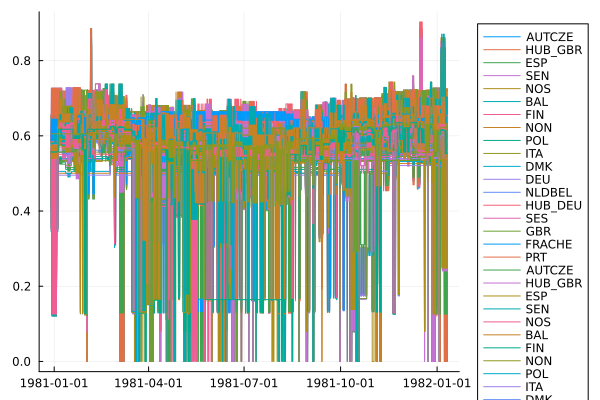

In [7]:
scenario = 1
index = collect(medprices[scenario]["steprange"])
prices = medprices[scenario]["matrix"]
labels = [name for name in medprices[scenario]["names"]]
p = plot(index,prices,label=reshape(labels, 1, length(labels)),legend=:outertopright)

for scenario in 2:5 # length(allscenarios)
    prices = medprices[scenario]["matrix"]
    labels = [name for name in medprices[scenario]["names"]]
    plot!(p,index,prices,label=reshape(labels, 1, length(labels)),legend=:outertopright)
end
display(p)

### Plot short term prices for some scenarios

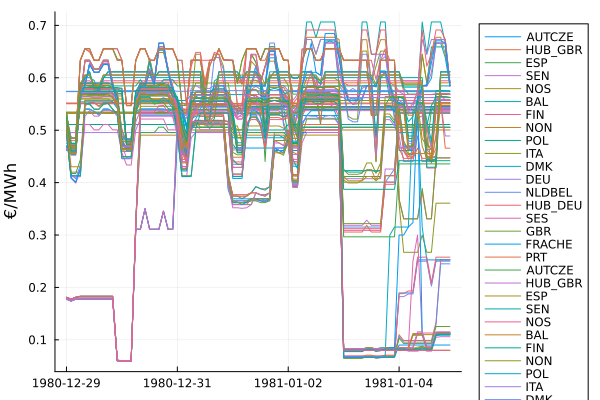

In [8]:
scenario = 1
index = collect(shortprices[scenario]["steprange"])
prices = shortprices[scenario]["matrix"]
labels = [name for name in shortprices[scenario]["names"]]
p = plot(index,prices,label=reshape(labels, 1, length(labels)), ylabel="€/MWh",legend=:outertopright)

for scenario in 2:5 # length(allscenarios)
    prices = shortprices[scenario]["matrix"]
    labels = [name for name in shortprices[scenario]["names"]]
    plot!(p, index,prices ,label=reshape(labels, 1, length(labels)),legend=:outertopright)
end
display(p)

### Stochastic subsystem models and market clearing model uses more detailed hydropower data

NVEs Europe dataset (explained above) combined with detailed hydropower for Norway and Sweden. The full detailed dataset contains for Nortwestern Europe:
- 32 price areas (9 exogen)
- 73 transmission lines (19 with ramping)
- 162 demands
- 88 batteries (normal, and representing demand response and V2G)
- 294 thermal plants (228 with start up costs)
- 100 wind and solar plants (aggregated)
- 1482 hydropower modules
    - 965 with production
    - 43 with pumps (includes PHS)
    - 998 with reservoirs
    - 788 restrictions (environmental, reservoir curves and ramping)
    - 90 PQ-curves (mostly Sweden)
    - Metadata for head dependency (nominal head, outlet level and reservoir curves) for some plants and pumps

NVEs dataset for the hydropower system in 2022 is open, but we have not published datasets for 2025/2030/2040/2050 since it would reveal investment plans. The dataset exist in several formats:
- Aggregated (for Res and RoR) production capacity, reservoir capacity, inflow and inflow profiles per price areas from https://www.nve.no/energi/analyser-og-statistikk/vaerdatasett-for-kraftsystemmodellene/
- Detailed watercourse descriptions from https://www.nve.no/energi/energisystem/vannkraft/modell-av-det-norske-vannkraftsystemet/. The dataset exist in two DETD-formats (per EMPS area (also includes rest modules for small-scale hydro) or per watercourse), and simplified in an Excel-format. The dataset used in this demo is derived from the excel-format with some differences: 
    - Every water balance has its own module (i.e. a module with both regulated and unregulated inflow is split into two modules). 
    - It has pq-kurves, reservoir curves (for head dependency) and environmental restrictions
    - It has ramping restrictions for hydropower release (only used in market clearing).
    - It has metadata for head dependency (nominal head, outlet level and reservoir curves) for some plants and pumps
- The inflow series for the detailed dataset can be found at https://www.nve.no/vann-og-vassdrag/hydrologiske-data/historiske-data/historiske-vannfoeringsdata-til-produksjonsplanlegging/. 

In [9]:
# Read dataset for stochastic and market clearing models
tst = JSON.parsefile(joinpath(sti_dataset, raw"data_fra_thema\dataset_thema_excl_hydro_nose.json")) # European dataset without aggregated hydro in Norway and Sweden
themastructure = getelements(tst) 
tse = JSON.parsefile(joinpath(sti_dataset, raw"data_fra_thema\tidsserier_thema.json"))
themaseries = getelements(tse, joinpath(sti_dataset,  "data_fra_thema"))

dse = JSON.parsefile(joinpath(sti_dataset, raw"data_fra_dynmodell\tidsserier_detd.json"))
detdseries = getelements(dse);
dst = JSON.parsefile(joinpath(sti_dataset, raw"data_fra_dynmodell\dataset_detd.json"))
detdstructure = getelements(dst);

detailedelements = vcat(themaseries,themastructure,detdseries,detdstructure)
addscenariotimeperiod_vector!(detailedelements, scenarioyearstart, scenarioyearstop);

#### Get water values for detailed hydro (DETD) from aggregated hydro (TheMA)
- With different representations of watercourses in different problems, we need a mapping
- TODO: Only use the detailed hydropower dataset and aggregate it for the price prognosis models. Now this aggregation is done outside of the model which gives the user less flexibility.

In [10]:
# Mapping between aggregated and detailed storages
detailedrescopl = JSON.parsefile(joinpath(sti_dataset, "data_fra_dynmodell/magasin_elspot1.json"))

# Global energy equivalent detailed reservoirs
enekvglobaldict = Dict()
for element in detailedelements
    if element.typename == GLOBALENEQKEY
        enekvglobaldict[split(element.instancename,"GlobalEneq_")[2]] = element.value["Value"]
    end
end

# Detailed dataset has reservoirs for SE4, aggregated does not, TODO: Improve aggregation/mapping
for k in keys(detailedrescopl)
    if detailedrescopl[k] == "SE4"
        detailedrescopl[k] = "SE3"
    end
end

# Get dictionary with each detailed reservoir and their water value for each scenario
# TODO: Detailed run-of-river reservoirs get water value from aggregated reservoir hydro
function getendvaluesdicts(endvaluesobjs, detailedrescopl::Dict, enekvglobaldict::Dict)
    endvaluesdicts = Dict[]
    for endvaluesobj in endvaluesobjs
        instance = [getinstancename(getid(obj)) for obj in endvaluesobj.objects]
        endvalues = endvaluesobj.values
        endvaluesdict = Dict(instance .=> endvalues)

        for (k,v) in detailedrescopl
            endvaluesdict["Reservoir_" * k] = endvaluesdict["Reservoir_" * v * "_hydro_reservoir"] * enekvglobaldict[k]
        end
        push!(endvaluesdicts, endvaluesdict)
    end
    
    return endvaluesdicts
end
medendvaluesdicts = getendvaluesdicts(medendvaluesobjs, detailedrescopl, enekvglobaldict);

### Scenario modelling

We use scenario modelling to consider uncertainty from 30 scenarios with only 7 scenarios. Scenarios can be chosen and weighted with different methods.
- In this prototype we use InflowClusteringMethod which cluster together scenarios with similar total energy inflows in the whole dataset (both level and profile). One scenario from each cluster will represent the others with the weight based on the size of the cluster.

This is implemented with modularity in mind, so you can chose other methods aswell or implement your own:
- NoScenarioModellingMethod keeps all the 30 scenarios
- SumInflowQuantileMethod calculates the total inflow in each scenario, puts them on a Bell curve and lets the user choose scenarios based on quantiles of the distribution. The user can also decide how to weight the scenarios with a polynomial function (for example weight the extremes more, only the wet years or only the dry years more)

TODO: 
- Now we do the scenario modelling based on the energy inflow in the whole dataset. This works ok since the most important subsystem models are the watercourses in the Nordics. But the scenarios chosen will work worse for the battery systems. In the future we would like to have different scenario modelling for different technologies and systems in different geographical areas. Other alternatives could be to do the scenario modelling based on the price series, or with the residual load (including energy inflow.)
- We also want to implement more complex scenario generation. This modular design of JulES gives us the flexibility to in the future generate inflow series for each watercourse with state information like snow reservoir levels and weather forecasts.

In [11]:
# Scenario reduction to this amount
numscen = 7

# Modelobjects that can be used to reduce scenarios
scenarioelements = copy(detailedelements)

# Horizons are needed to build modelobjects, but not used in scenario modelling
dummyperiods = 10
dummyperiodduration = Millisecond(Hour(24))
power_horizon = SequentialHorizon(dummyperiods, dummyperiodduration)
hydro_horizon = SequentialHorizon(dummyperiods, dummyperiodduration)

set_horizon!(scenarioelements, "Power", power_horizon)
set_horizon!(scenarioelements, "Battery", power_horizon)
set_horizon!(scenarioelements, "Hydro", hydro_horizon)

scenarioobjects = collect(values(getmodelobjects(scenarioelements)))

# Scenario modelling method
scendelta = MsTimeDelta(Day(364)) # scenario modelling based on the next year, even though the scenario problems can be longer
parts = 4 # divide scendelta into this many parts, calculate sum inflow for each part of the inflow series, then use clustering algorithm
scenmodmethod = InflowClusteringMethod(numscen, parts)
# scenmodmethod = NoScenarioModellingMethod(numscen, totalscentimes)
@time scenariomodelling!(scenmodmethod, scenarioobjects, numscen, totalscentimes, scendelta); # see JulES/scenariomodelling.jl

  5.025000 seconds (8.18 M allocations: 438.236 MiB, 3.82% gc time, 95.86% compilation time)


### Stochastic subsystem models with Benders decomposition
- Each unique storage system (watercourses or batteries) is solved as a two-stage stochastic LP with Benders decomposition
- The subsystems are optimized against exogen prices from the price prognosis scenarios
- We group storage systems into two. These are solved with different degree of detail
    - Med-term - mostly hydro
        - 52 week long horizon, weekly resolution, price from medium term price prognosis
    - Short-term - mostly batteries and PHS
        - Week long horizon, two-hourly resolution, price from short term price prognosis
- Outputs:
    - Cuts (battery or hydro) for use as end condition in market clearing problem

In [12]:
# Cut parameters
maxcuts = 13 # preallocate fixed number of cuts, no cut selection
lb = -1e5 # lower bound of the future value in the first iteration
reltol = 0.0001 # relative tolerance

# Parameters for stochastic subsystem problems (could also split totalduration into master- and subduration)
shortstartstorage = 50
medstartstorage = 65
smpdp = Millisecond(Hour(2)) # short/med - master/sub - period duration - power/hydro (commodity)
smpdh = Millisecond(Hour(2))
sspdp = Millisecond(Hour(2))
sspdh = Millisecond(Hour(2)) # both master and subproblems for PHS and batteries has 2 hour resolution
mmpdp = Millisecond(Hour(24))
mmpdh = Millisecond(Hour(24)) # daily resolution in hydro master problems
mspdp = Millisecond(Hour(168))
mspdh = Millisecond(Hour(168)) # weekly resolution in hydro subproblems
shorttotalduration = shorthorizonduration # total duration of master and subproblem
medtotalduration = medhorizonduration - Millisecond(Week(2)) # we reuse prices for two weeks, so have to be two weeks shorter than price prognosis problem

# Make sure time resolution of hydro and power are compatible (TODO: Could add function that makes them compatible)
@assert ceil(Int64, phaseinoffset/smpdp) == ceil(Int64, phaseinoffset/smpdh)
@assert ceil(Int64, (shorttotalduration-phaseinoffset)/sspdp) == ceil(Int64, (shorttotalduration-phaseinoffset)/sspdh)
@assert ceil(Int64, phaseinoffset/mmpdp) == ceil(Int64, phaseinoffset/mmpdh)
@assert ceil(Int64, (medtotalduration-phaseinoffset)/mspdp) == ceil(Int64, (medtotalduration-phaseinoffset)/mspdh)

# Convert DistributedArray of prices to local process
medpriceslocal = convert(Vector{Dict}, medprices)
shortpriceslocal = convert(Vector{Dict}, shortprices)

# Inputs
storageinfo = (shortstartstorage, medstartstorage, medendvaluesdicts)
shortterminputs = (detailedelements, shorttotalduration, smpdp, smpdh, sspdp, sspdh, scenmodmethod.scentimes, phaseinoffset, shortpriceslocal, true)
medterminputs = (detailedelements, medtotalduration, mmpdp, mmpdh, mspdp, mspdh, scenmodmethod.scentimes, phaseinoffset, medpriceslocal, false)

ustoragesystemobjects = []
ushorts = []
# Make modelobjects for short-term subsystems
@time makemastersubobjects!(shortterminputs, ustoragesystemobjects, ushorts)
# Make modelobjects for medium-term subsystems
@time makemastersubobjects!(medterminputs, ustoragesystemobjects, ushorts)

# Distribute subsystems with inputs and outputs on different cores
storagesystemobjects, shorts = distribute_subsystems(ustoragesystemobjects, ushorts) # somewhat smart distribution of subsystems to cores based on how many modelobjects in eac subsystem
masters = distribute([HiGHS_Prob() for i in 1:length(storagesystemobjects)], storagesystemobjects)
subs = distribute([[] for i in 1:length(storagesystemobjects)], storagesystemobjects)
states = distribute([Dict{StateVariableInfo, Float64}() for i in 1:length(storagesystemobjects)], storagesystemobjects)
cuts = distribute([SimpleSingleCuts() for i in 1:length(storagesystemobjects)], storagesystemobjects)
storagesystems = distribute([Dict() for i in 1:length(storagesystemobjects)], storagesystemobjects)

# Which solver and settings should we use for each problem?
probmethodsstochastic = [HighsSimplexMethod(warmstart=true), HighsSimplexMethod(warmstart=true)]

# Initialize subsystem problems and run for first time step. Run subsystems in parallell
@time pl_stochastic_init!(probmethodsstochastic, numcores, storagesystemobjects, shorts, masters, subs, states, cuts, storageinfo, lb, maxcuts, reltol, scenmodmethod.scentimes)

  5.660007 seconds (11.81 M allocations: 562.943 MiB, 62.51% compilation time)
  2.544458 seconds (9.72 M allocations: 429.166 MiB, 7.81% gc time, 7.47% compilation time)
  7.399746 seconds (2.23 M allocations: 70.306 MiB, 3.67% compilation time)


Task (done) @0x0000024d7a9587d0

### Market clearing problem
- Deterministic LP
- Two days, full detail (hydro and thermal), two-hourly resolution for power, 6 hourly resolution for hydro
- Inputs:
    - Detailed power market representation
    - Water values and battery storage values from stochastic subsystem problems
    - Thermal end condition from short term price prognosis model
- Outputs:
    - Two day detailed power market simulation (price, production, reservoir etc...)
    - Start state for next time step (reservoirs and other state variables)

In [13]:
# Bring data to local core
masterslocal = convert(Vector{Prob}, masters)
cutslocal = convert(Vector{SimpleSingleCuts}, cuts)
nonstoragestateslocal = convert(Vector{Dict}, nonstoragestates)

# Initialize market clearing problem and run for first time step
cpdp = Millisecond(Hour(2)) # clearing period duration power/battery
cnpp = ceil(Int64, phaseinoffset/cpdp) # clearing numperiods power/battery
cpdh = Millisecond(Hour(6)) # clearing period duration hydro
# cpdh = Millisecond(Hour(2)) # clearing period duration hydro
cnph = ceil(Int64, phaseinoffset/cpdh) # clearing numperiods hydro
probmethodclearing = HighsSimplexPAMIMethod(warmstart=false) # Which solver and settings should we use for each problem?
@time clearing, nonstoragestatesmean, varendperiod = clearing_init(probmethodclearing, detailedelements, tnormal, phaseinoffset, cpdp, cpdh, masterslocal, cutslocal, nonstoragestateslocal);

 14.065362 seconds (11.73 M allocations: 811.872 MiB, 3.64% gc time, 46.29% compilation time)


In [14]:
# Initialize start states for next time step, also mapping to TheMA storages and max capacity in TheMA-storages
startstates = startstates_init(clearing, detailedrescopl, enekvglobaldict, longprobs[1], tnormal);

#### Head dependency in clearing_init!() and clearing!()

Inside the market clearing we have implemented head dependency:
- These functions sets state/head dependent energy equivalents for production and pumping 
    - statedependentprod_init!(clearing, 65, t)
    - statedependentpump_init!(clearing, 65, t)
- We use the headloss cost method ReservoirCurveSlopeMethod which increases the watervalue if a small increase in reservoir filling would give a higher head at the current reservoir filling. The head loss cost is based on the slope of the reservoir curve (reservoir height [m] to filling [Mm3]) at the current reservoir filling. To get the headloss cost, we multiply the water value with a factor of the percentage change in the height for a 2% change in the reservoir filling divided by 2% (a bit simplified). An example of a reservoir with a steep reservoir curve is Storglomvatn belonging to Svartisen, so the headloss cost will incentivise a higher reservoir filling to get a higher head and energy equivalent at production.
    - updateheadlosscosts!(ReservoirCurveSlopeMethod(), clearing, masterslocal, t)
    
See the code at TuLiPa/reasoning_nvehydro.jl

TODO: Make an interface for head dependency to support different methods. The method used in this demo is relatively simple since we only consider head dependency in the market clearing, but we have methods that also consider head dependency in the master and subproblems of the stochastic subsystem models.

### Initialize and collect results: Prices and start states (e.g. reservoirs)

In [15]:
# Initialize and collect prices and start states
price = Dict()
powerhorizonix = argmax(getnumperiods(h) for h in clearing.horizons)
getareaprices!(price, clearing, clearing.horizons[powerhorizonix], tnormal)
areanames = price["names"]
ix = collect(price["steprange"])
pricematrix = copy(price["matrix"])

statenames = collect(keys(startstates))
statematrix = collect(values(startstates));

#### Collect more detailed results
- Prices, supply, demand, transmission and hydro storage levels

In [16]:
clearingobjects = Dict(zip([getid(obj) for obj in clearing.objects],clearing.objects)) # collect results from all areas
# resultobjects = getpowerobjects(clearingobjects,["NO2"]); # only collect results for one area
resultobjects = clearing.objects # collect results for all areas
prices, rhstermvalues, production, consumption, hydrolevels, batterylevels, powerbalances, rhsterms, rhstermbalances, plants, plantbalances, plantarrows, demands, demandbalances, demandarrows, hydrostorages, batterystorages = init_results(clearing, clearingobjects, resultobjects, cnpp, cnph, cpdp, tnormal, false);

### Simulate next time steps (16 steps = 32 days)
- Simulate next time steps, store results and plot results

In [17]:
# Only do scenario modelling and calculate new cuts every 8 days (other reuse scenarios and cuts)
skipmed = Millisecond(Day(0))
skipmax = Millisecond(Day(6))

# How many time steps to run the simulation for
steps = 16;
# steps = (getisoyearstart(scenarioyearstop) - getisoyearstart(scenarioyearstart)).value/phaseinoffset.value;

In [18]:
step = 2 # already ran first step in initialization

totaltime = @elapsed while step <= steps # while step <= steps and count elapsed time
    # Increment simulation/main scenario and uncertainty scenarios
    tnormal += phaseinoffset
    display(tnormal)

    for i in 1:length(totalscentimes)
        (scentnormal, scentphasein, scenario) = totalscentimes[i]
        scentnormal += phaseinoffset
        scentphasein = PhaseinTwoTime(getdatatime(scentnormal), getscenariotime(scentnormal), getscenariotime(scentnormal), phaseinoffset, phaseindelta, phaseinsteps)
        totalscentimes[i] = (scentnormal, scentphasein, scenario)
    end

    # Increment skipmed - should we reuse watervalues this time step?
    skipmed += Millisecond(phaseinoffset)
    if skipmed > skipmax
        skipmed = Millisecond(0)
    end

    # Deterministic long/mid/short - calculate scenarioprices for all 30 scenarios
    allscenarios = distribute(totalscentimes, allscenarios) # TODO: Find better solution
    @time pl_prognosis!(numcores, longprobs, medprobs, shortprobs, medprices, shortprices, nonstoragestates, startstates, allscenarios, skipmed)

    # Stochastic sub systems - calculate storage value    
    if skipmed.value == 0
        # Choose new scenarios
        scenariomodelling!(scenmodmethod, scenarioobjects, numscen, totalscentimes, scendelta)
        
        medpriceslocal = convert(Vector{Dict}, medprices)
        medendvaluesdicts = getendvaluesdicts(medendvaluesobjs, detailedrescopl, enekvglobaldict)
    else
        # Increment existing scenarios
        for i in 1:length(scenmodmethod.scentimes)
            (scentnormal, scentphasein, scenario) = scenmodmethod.scentimes[i]
            scentnormal += phaseinoffset
            scentphasein = PhaseinTwoTime(getdatatime(scentnormal), getscenariotime(scentnormal), getscenariotime(scentnormal), phaseinoffset, phaseindelta, phaseinsteps)
            scenmodmethod.scentimes[i] = (scentnormal, scentphasein, scenario)
        end
    end
    shortpriceslocal = convert(Vector{Dict}, shortprices)

    @time pl_stochastic!(numcores, masters, subs, states, cuts, startstates, medpriceslocal, shortpriceslocal, medendvaluesdicts, shorts, reltol, scenmodmethod.scentimes, skipmed)

    # Market clearing
    masterslocal = convert(Vector{Prob}, masters)
    cutslocal = convert(Vector{SimpleSingleCuts}, cuts)
    nonstoragestateslocal = convert(Vector{Dict}, nonstoragestates)

    @time clearing!(clearing, tnormal, startstates, masterslocal, cutslocal, nonstoragestateslocal, nonstoragestatesmean, detailedrescopl, enekvglobaldict, varendperiod)

    # Results
    updateareaprices!(price, clearing, clearing.horizons[powerhorizonix], tnormal)
    ix = vcat(ix, collect(price["steprange"]))
    pricematrix = vcat(pricematrix, price["matrix"])
    statematrix = hcat(statematrix, collect(values(startstates)))

    prices, rhstermvalues, production, consumption, hydrolevels, batterylevels = update_results(clearing, prices, rhstermvalues, production, consumption, hydrolevels, batterylevels, powerbalances, rhsterms, plants, plantbalances, plantarrows, demands, demandbalances, demandarrows, hydrostorages, batterystorages, clearingobjects, cnpp, cnph, cpdp, tnormal);    

    # Increment step
    step += 1
end

display(string("The simulation took: ", totaltime/60, " minutes"))
display(string("Time usage per timestep: ", totaltime/steps, " seconds"))

FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1980-12-31T00:00:00"))

  5.203408 seconds (129.56 k allocations: 8.422 MiB, 1.06% compilation time)


Unhandled Task ERROR: On worker 2:
UndefVarError: `_setconduals!` not defined
Stacktrace:
  [1] stochastic!
    @ C:\Users\petoth\NVE\JulES\src\stochastic.jl:362
  [2] macro expansion
    @ C:\Users\petoth\NVE\JulES\src\stochastic.jl:381 [inlined]
  [3] #179
    @ C:\Users\petoth\AppData\Local\Programs\Julia-1.9.2\share\julia\stdlib\v1.9\Distributed\src\macros.jl:303
  [4] #178
    @ C:\Users\petoth\AppData\Local\Programs\Julia-1.9.2\share\julia\stdlib\v1.9\Distributed\src\macros.jl:83
  [5] #invokelatest#2
    @ .\essentials.jl:816 [inlined]
  [6] invokelatest
    @ .\essentials.jl:813
  [7] #107
    @ C:\Users\petoth\AppData\Local\Programs\Julia-1.9.2\share\julia\stdlib\v1.9\Distributed\src\process_messages.jl:281
  [8] run_work_thunk
    @ C:\Users\petoth\AppData\Local\Programs\Julia-1.9.2\share\julia\stdlib\v1.9\Distributed\src\process_messages.jl:70
  [9] run_work_thunk
    @ C:\Users\petoth\AppData\Local\Programs\Julia-1.9.2\share\julia\stdlib\v1.9\Distributed\src\process_message

LoadError: TaskFailedException

[91m    nested task error: [39mOn worker 2:
    UndefVarError: `_setconduals!` not defined
    Stacktrace:
      [1] [0m[1mstochastic![22m
    [90m    @[39m [90mC:\Users\petoth\NVE\JulES\src\[39m[90m[4mstochastic.jl:362[24m[39m
      [2] [0m[1mmacro expansion[22m
    [90m    @[39m [90mC:\Users\petoth\NVE\JulES\src\[39m[90m[4mstochastic.jl:381[24m[39m[90m [inlined][39m
      [3] [0m[1m#179[22m
    [90m    @[39m [90mC:\Users\petoth\AppData\Local\Programs\Julia-1.9.2\share\julia\stdlib\v1.9\Distributed\src\[39m[90m[4mmacros.jl:303[24m[39m
      [4] [0m[1m#178[22m
    [90m    @[39m [90mC:\Users\petoth\AppData\Local\Programs\Julia-1.9.2\share\julia\stdlib\v1.9\Distributed\src\[39m[90m[4mmacros.jl:83[24m[39m
      [5] [0m[1m#invokelatest#2[22m
    [90m    @[39m [90m.\[39m[90m[4messentials.jl:816[24m[39m[90m [inlined][39m
      [6] [0m[1minvokelatest[22m
    [90m    @[39m [90m.\[39m[90m[4messentials.jl:813[24m[39m
      [7] [0m[1m#107[22m
    [90m    @[39m [90mC:\Users\petoth\AppData\Local\Programs\Julia-1.9.2\share\julia\stdlib\v1.9\Distributed\src\[39m[90m[4mprocess_messages.jl:281[24m[39m
      [8] [0m[1mrun_work_thunk[22m
    [90m    @[39m [90mC:\Users\petoth\AppData\Local\Programs\Julia-1.9.2\share\julia\stdlib\v1.9\Distributed\src\[39m[90m[4mprocess_messages.jl:70[24m[39m
      [9] [0m[1mrun_work_thunk[22m
    [90m    @[39m [90mC:\Users\petoth\AppData\Local\Programs\Julia-1.9.2\share\julia\stdlib\v1.9\Distributed\src\[39m[90m[4mprocess_messages.jl:79[24m[39m
     [10] [0m[1m#100[22m
    [90m    @[39m [90m.\[39m[90m[4mtask.jl:514[24m[39m
    
    ...and 29 more exceptions.
    
    Stacktrace:
     [1] [0m[1msync_end[22m[0m[1m([22m[90mc[39m::[0mChannel[90m{Any}[39m[0m[1m)[22m
    [90m   @[39m [90mBase[39m [90m.\[39m[90m[4mtask.jl:445[24m[39m
     [2] [0m[1m(::Distributed.var"#177#179"{var"#179#180"{DArray{HiGHS_Prob, 1, Vector{HiGHS_Prob}}, DArray{Vector{Any}, 1, Vector{Vector{Any}}}, DArray{Dict{StateVariableInfo, Float64}, 1, Vector{Dict{StateVariableInfo, Float64}}}, DArray{SimpleSingleCuts, 1, Vector{SimpleSingleCuts}}, Dict{String, Float64}, Vector{Dict}, Vector{Dict}, Vector{Dict}, DArray{Any, 1, Vector{Any}}, Float64, Vector{Tuple{FixedDataTwoTime, PhaseinTwoTime, Int64}}, Millisecond}, UnitRange{Int64}})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [35mDistributed[39m [90m.\[39m[90m[4mtask.jl:477[24m[39m

### Results

In the first phase of JulES we have prioritized implementing functionality and test that they give the intended results, and compared results against other long-term models (TheMA and Samnett, which give a sufficient basis for comparison) on a big dataset. The price formation, reservoir operation and runtime of JulES seems promising, but there remains a lot of testing to see all the impacts of the concept implementation, model parameters, scenario modelling and head dependency on water values, prices, reservoir operation and runtime. The testing has been restricted by the runtime of the model, which we will have to improve to test different parts of the model more efficiently. In the next phase we want to test JulES as a short/medium-term paralell-simulation prognosis model. The results can then be compared to our other prognosis model (EMPS) and quickly be compared to the real market and historical data.

Throughout the testing we have achieved the wanted price volatility in the thermal dominated part of the dataset (Western Europe). On the other hand, the Nordics have had very flat prices due to too much flexibility in the hydropower modelling. We have therefore added hydropower production ramping restrictions in the market clearing in an attempt to reduce the flexibility of the run-of-river hydropower plants. This results in much more price volatiliy, but at a big computational cost. Ramping restrictions on transmission lines has the same effect.

Time usage with the current implementation in the demo and serial simulation of 30 weather years (~5500 two day long time steps):
- Same as demo: 2 hourly power resolution and 6 hourly hydro resolution in market clearing and hydro ramping restrictions
    - 46 hours total or 30 sec per time step or 105 sec per week
- 2 hourly hydro resolution in market clearing and hydro ramping restrictions (no other difference to demo)
    - 78 hours total or 51 sec per time step or 180 sec per week
- 24 hourly hydro resolution in market clearing and no hydro ramping restrictions (no other difference to demo)
    - 20 hours total or 13 sec per time step or 45 sec per week

This is promising considering the big dataset, and the list of possible optimization we have in mind:
- At the moment we solve the market clearing problem with the HiGHS serial Simplex method, which could be replaced by a method that uses parallelization. The HiGHS PAMI Simplex method is a good option that is faster, but there are also other open-source solvers that should be tested.
- It is interesting what these computational times would be with a commercial solver (we now use HiGHS), and with more and faster processor cores in parallel (now 30 2.2 GHz processor cores). 
- We could clear the market for 24 hours at a time instead of 48 hours like now, which could reduce the computational time depending on if the market clearing has a higher runtime than the stochastic subsystem and price prognosis models (this is the case when we have a very detailed market clearing). 
- We could try different configurations of ramping restrictions, and test if time delays in watercourses can achieve the same effects at a lower computation cost. Considering unavailability of hydropower or reserve market obligations, should also decrease the flexibility of the hydropower system. Detailed transmission system modelling should also be implemented in the future.
- We could run the model only for the Nordics, which would reduce the size of the dataset substantially and give results that are comparable to other models we use.

The price levels in the Nordics are higher than in other models. This is partly due to the high flexibility in the hydropower modelling, which gives stable high prices and not many zero-prices. Another reason is that the stochastic subsystem models could need some improvements, for example longer and more detailed horizons. This should give water values that gives better long term signals. More load shedding can also be a contributor to higher prices, but this can be prevented with scenario modelling and head dependencies.

We have also seen the effects of scenario modelling and head dependencies. Scenario modelling can be used to reduce the runtime and adjust the risk taking, which gives more realistic reservoir operation and avoid the extremes of flooding and load shedding. Head dependency can be used to get a more realistic reservoir operation and higher production, and also gives lower risk of load shedding. These have to be tested further.

We are also very happy with the modelling choice of modularity, using time-series datasets and using Julia. This has made TuLiPa and JulES very pleasant to work with, as they provide a great deal of flexibility in adding complex functionality without having to make extensive changes to the existing code. Additionally, the models can be run with different methods and time resolutions without adaptations of the dataset. These design choices contribute to the model's suitability for further development and modeling the future power system when new modeling requirements arise.

However, the project's codebase needs to be professionalized with better structure to make the model more user-friendly, allowing not only developers to run the model. Unit testing is also important to ensure that the model functions as intended. So far, we have been working on the model concept alone, so it will be crucial to involve analysts who will use the models and developers outside of NVE who can contribute to further developing the concept.

### Postprocess detailed results
- Combine fixed contributions (e.g. wind, solar and demand) together with supply and demand variables
- Make time axis for price, supply/demand and reservoir levels

In [19]:
# Only keep rhsterms that have at least one value (TODO: Do the same for sypply and demands)
rhstermtotals = dropdims(sum(rhstermvalues,dims=1),dims=1)
rhstermsupplyidx = []
rhstermdemandidx = []

for k in 1:length(rhsterms)
    if rhstermtotals[k] > 0
        push!(rhstermsupplyidx, k)
    elseif rhstermtotals[k] < 0
        push!(rhstermdemandidx, k)
    end
end

# Put rhsterms together with supplies and demands
rhstermsupplyvalues = rhstermvalues[:,rhstermsupplyidx]
rhstermdemandvalues = rhstermvalues[:,rhstermdemandidx]*-1

rhstermsupplynames = [getinstancename(rhsterm) for rhsterm in rhsterms[rhstermsupplyidx]]
rhstermsupplybalancenames = [split(getinstancename(r), "PowerBalance_")[2] for r in rhstermbalances[rhstermsupplyidx]]
rhstermdemandnames = [getinstancename(rhsterm) for rhsterm in rhsterms[rhstermdemandidx]]
rhstermdemandbalancenames = [split(getinstancename(r), "PowerBalance_")[2] for r in rhstermbalances[rhstermdemandidx]]

supplynames = [[getinstancename(plant) for plant in plants];rhstermsupplynames]
supplybalancenames = [[split(getinstancename(p), "PowerBalance_")[2] for p in plantbalances];rhstermsupplybalancenames]
supplyvalues = hcat(production,rhstermsupplyvalues)

demandnames = [[getinstancename(demand) for demand in demands];rhstermdemandnames]
demandbalancenames = [[split(getinstancename(p), "PowerBalance_")[2] for p in demandbalances];rhstermdemandbalancenames]
demandvalues = hcat(consumption, rhstermdemandvalues)

# Prepare for plotting results
hydronames = [getinstancename(hydro) for hydro in hydrostorages]
batterynames = [getinstancename(battery) for battery in batterystorages]
powerbalancenames = [split(getinstancename(getid(powerbalance)), "PowerBalance_")[2] for powerbalance in powerbalances]

# Convert reservoir filling to TWh
hydrolevels1 = copy(hydrolevels)
for (i,hydroname) in enumerate(hydronames)
    if haskey(getbalance(clearingobjects[hydrostorages[i]]).metadata, GLOBALENEQKEY)
        hydrolevels1[:,i] = hydrolevels1[:,i]*getbalance(clearingobjects[hydrostorages[i]]).metadata[GLOBALENEQKEY]
    end
end

# Time
x1 = [getisoyearstart(scenarioyearstart) + cpdp*(t-1) for t in 1:first(size(supplyvalues))] # power/load resolution
x2 = [getisoyearstart(scenarioyearstart) + cpdh*(t-1) for t in 1:first(size(hydrolevels))]; # reservoir resolution

In [20]:
# # Store results with binary h5 format
# datetimeformat = "yyyy-mm-ddTHH:MM:SS"
# modelname = JulES_2030_81_10

# data = Dict()
# data["areanames"] = areanames |> Vector{String}
# data["pricematrix"] = pricematrix
# data["priceindex"] = Dates.format.(ix, datetimeformat) # not necessary to store as string

# data["statenames"] = statenames
# data["statematrix"] = permutedims(statematrix)
# data["stateindex"] =  Dates.format.([getisoyearstart(scenarioyearstart) + Day(2*(i-1)) for i in 1:first(size(transpose(statematrix)))], datetimeformat)

# data["supplyvalues"] = supplyvalues
# data["supplynames"] = supplynames
# data["supplybalancenames"] = supplybalancenames

# using FileIO, HDF5
# @time h5open("$modelname.h5", "w") do file
#     for (k,v) in data
#         display(k)
#         write(file, k, v)
#     end
# end

# # # Read results so that they can be compared to other models (we have another script that compares JulES with Samnett and TheMA)
# # # Read using JLD2
# # using JLD2
# # @time JulESdata = JLD2.load("$modelname.h5")

# # # Read using HDF5
# # JulESdata = Dict{String, Any}()
# # @time c = h5open("$modelname.h5", "r") do file
# #     for key in keys(data)
# #         JulESdata[key] = read(file, key)
# #     end
# # end

# # Store as CSV
# areaprices = rename!(DataFrame(prices, :auto),powerbalancenames)
# areaprices[!,:time] = x1
# CSV.write("JulES_results\\prices.csv", areaprices)

# demand = rename!(DataFrame(demandvalues, :auto),demandnames)
# demand[!,:time] = x1
# demand = stack(demand,Not(:time))
# demandcopl = DataFrame(variable=demandnames, area=demandbalancenames)
# demand = leftjoin(demand, demandcopl, on=:variable)
# CSV.write("JulES_results\\demand.csv", demand)

# supply = rename!(DataFrame(supplyvalues, :auto),supplynames)
# supply[!,:time] = x1
# supply = stack(supply,Not(:time))
# supplycopl = DataFrame(variable=supplynames, area=supplybalancenames)
# supply = leftjoin(supply, supplycopl, on=:variable)
# CSV.write("JulES_results\\supply.csv", supply)

# hydro = rename!(DataFrame(hydrolevels, :auto),hydronames)
# hydro[!,:time] = x2
# CSV.write("JulES_results\\hydro.csv", hydro);

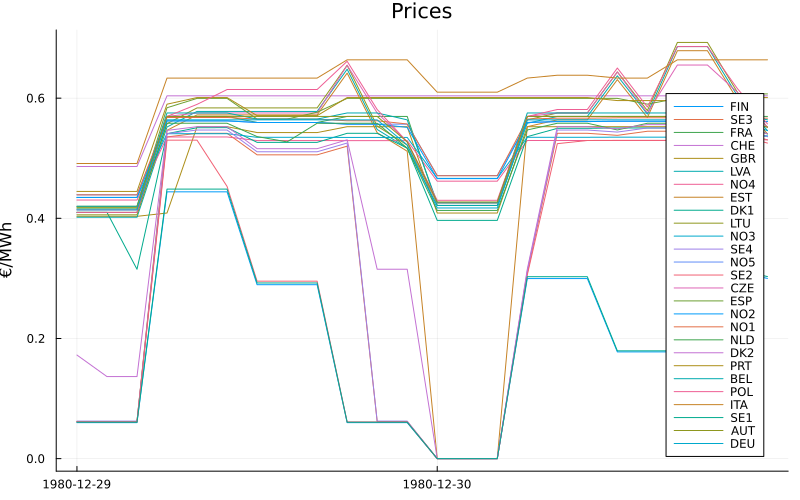

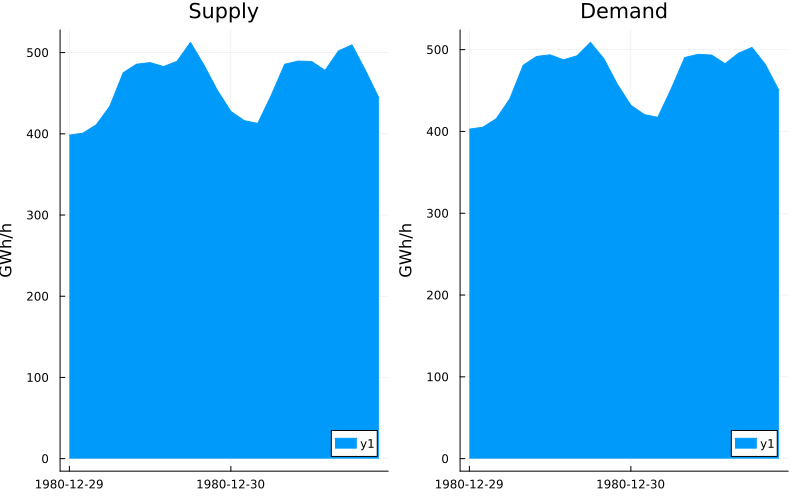

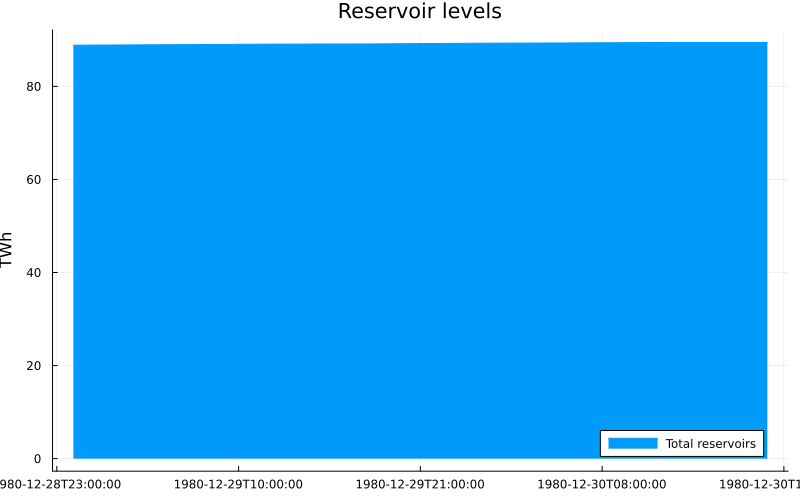

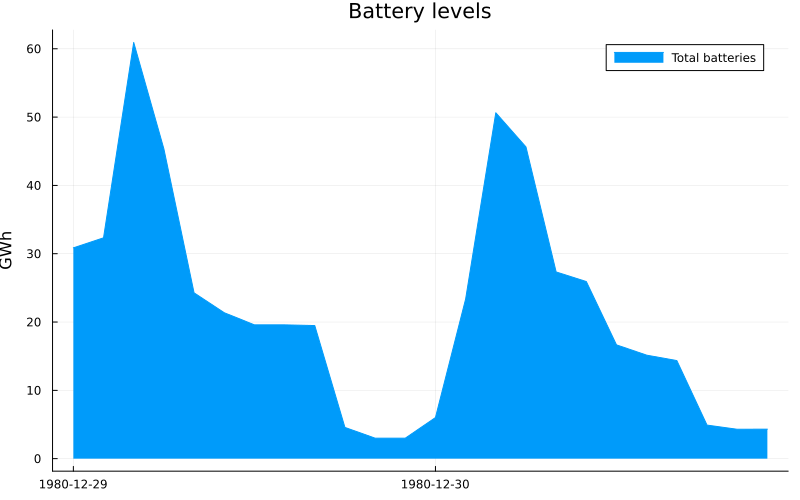

1×2 DataFrame
 Row │ Yearly_supply_TWh_sum_skipmissing  Yearly_demand_TWh_sum_skipmissing 
─────┼──────────────────────────────────────────────────────────────────────
   1 │                           4049.75                            4079.73

In [21]:
# Plot prices
idxwohub = findall(x -> !occursin("HUB", x), powerbalancenames) # remove hubs, not active in 2025 dataset
display(plot(x1, prices[:,idxwohub], labels=reshape(powerbalancenames[idxwohub],1,length(powerbalancenames[idxwohub])), size=(800,500), title="Prices", ylabel="€/MWh"))

# # Plot supplies and demands
# supplychart = plot(x1, supplyvalues,labels=reshape(supplynames,1,length(supplynames)),title="Supply", ylabel = "GWh/h")
# demandchart = plot(x1, demandvalues,labels=reshape(demandnames,1,length(demandnames)),title="Demand", ylabel = "GWh/h")
supplychart = areaplot(x1, sum(supplyvalues,dims=2),title="Supply", ylabel = "GWh/h")
demandchart = areaplot(x1, sum(demandvalues,dims=2),title="Demand", ylabel = "GWh/h")
display(plot([supplychart,demandchart]...,layout=(1,2),size=(800,500)))

# Plot storages
# display(areaplot(x2, hydrolevels1,labels=reshape(hydronames,1,length(hydronames)),size=(800,500),title="Reservoir levels", ylabel = "TWh")) #
display(areaplot(x2, dropdims(sum(hydrolevels,dims=2),dims=2),labels="Total reservoirs",size=(800,500),title="Reservoir levels", ylabel = "TWh")) #

display(areaplot(x1, dropdims(sum(batterylevels,dims=2),dims=2),labels="Total batteries",size=(800,500),title="Battery levels", ylabel = "GWh")) #

# Plot list of yearly mean production and demand for each supply/demand
meandemand = dropdims(mean(demandvalues,dims=1),dims=1)
meanproduction = dropdims(mean(supplyvalues,dims=1),dims=1)
supplydf = sort(DataFrame(Supplyname = supplynames, Yearly_supply_TWh = meanproduction*8.76),[:Yearly_supply_TWh], rev = true)
demanddf = sort(DataFrame(Demandname = demandnames, Yearly_demand_TWh = meandemand*8.76),[:Yearly_demand_TWh], rev = true)
supplydf[!,:ID] = collect(1:length(supplynames))
demanddf[!,:ID] = collect(1:length(demandnames))
joineddf = select!(outerjoin(supplydf,demanddf;on=:ID),Not(:ID))
# show(joineddf,allcols=true, allrows=true, nosubheader = true)

# Check that total supply equals total demand
show(combine(joineddf, [:Yearly_supply_TWh, :Yearly_demand_TWh] .=> sum∘skipmissing), nosubheader = true)

# # Plot list of yearly income and cost for each supply/demand (only works if exogenprices are collected)
# supplyrev = copy(supplyvalues)
# for (i,supplybalancename) in enumerate(supplybalancenames)
#     idx = findfirst(isequal(supplybalancename), powerbalancenames)
#     supplyrev[:,i] .= supplyrev[:,i] .* prices[:,idx]
# end
# demandrev = copy(demandvalues)
# for (i,demandbalancename) in enumerate(demandbalancenames)
#     idx = findfirst(isequal(demandbalancename), powerbalancenames)
#     demandrev[:,i] .= demandrev[:,i] .* prices[:,idx]
# end
# meandemandrev = dropdims(mean(demandrev,dims=1),dims=1)
# meanproductionrev = dropdims(mean(supplyrev,dims=1),dims=1)
# supplyrevdf = sort(DataFrame(Supplyname = supplynames, Yearly_rev_mill€ = meanproductionrev*8.76),[:Yearly_rev_mill€], rev = true)
# demandrevdf = sort(DataFrame(Demandname = demandnames, Yearly_cost_mill€ = meandemandrev*8.76),[:Yearly_cost_mill€], rev = true)
# supplyrevdf[!,:ID] = collect(1:length(supplynames))
# demandrevdf[!,:ID] = collect(1:length(demandnames))
# joinedrevdf = select!(outerjoin(supplyrevdf,demandrevdf;on=:ID),Not(:ID))
# # show(joinedrevdf,allcols=true, allrows=true, nosubheader = true)

# # Sum revenues and cost
# show(combine(joinedrevdf, [:Yearly_rev_mill€, :Yearly_cost_mill€] .=> sum∘skipmissing), nosubheader = true)

- Yearly_supply_TWh and Yearly_demand_TWh is the mean production timed with 8736.
- Transmission into the area is added to supply, while transmission out is added to demand.
- The reason why the supply does not match the demand is that the filtering does not split up watercourses where hydropower plants are in different areas. The supply side (of NO2) therefore contains 14 hydropower plants in NO1 and NO5.